In [313]:
import numpy as np
import os
from glob import glob

import pydicom as dicom
import cv2 
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import matplotlib.pyplot as plt
%matplotlib inline

#### 0. Data load

In [98]:
data_path = '/home/samsmu/Data/Lung/CT'
dataset = data_path + '/Ours/Test'

In [56]:
dcm_files = glob(dataset + "/*")
dcm_file = dcm_files[12]

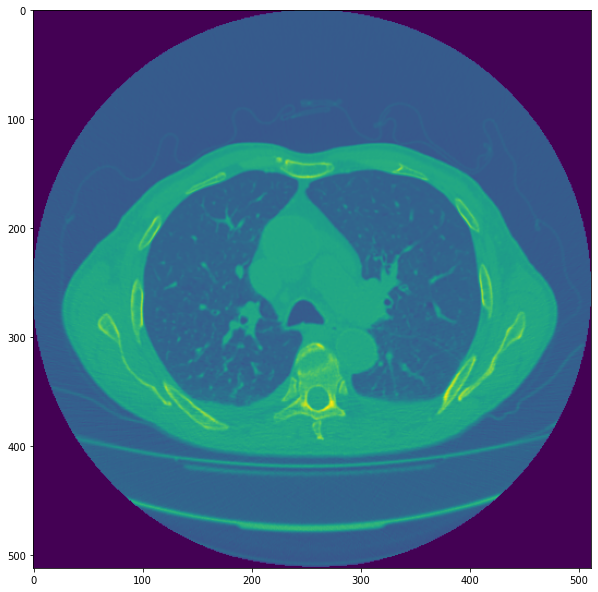

In [57]:
dcm = dicom.read_file(dcm_file)
img = dcm.pixel_array
fig = plt.figure(figsize = (10, 12))
plt.imshow(img)

## Preprocessing

#### 1. Считаем Slice tickness

Расстояние между кадрами (slice). Необходим для расчета реального размера вокселя (в мм.). Показатель может менятся для различных пациентов. Перед тренировкой сети провести нормализацию. Для нормализации нужно применять isomorphic resample.

In [139]:
# Пример процедуры расчета толщины кадры
def set_thickness(slices):
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [279]:
def load_scan(files):
    slices = [dicom.read_file(f) for f in files]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    poss = [s.ImagePositionPatient[2] for s in slices]
    thicks = np.diff(poss).tolist()
    thicks.append(thicks[-1]) # Добавляем в конец одно значение для соотвествия размеру
    for s, t in zip(slices, thicks):
        s.SliceThickness = t
    return slices

files = glob(dataset + '/IM-0002*.dcm')
slices = load_scan(files)

#### 2. Преобразование в Hounsfield Unit (HU) 

Все что меньше -1000 считаем воздухом, все что больше 600 костями. После работы сканнера на изображении остается круг, убираем его.

In [242]:
# Convert to Hounsfield units (HU)
images = np.stack([s.pixel_array for s in slices])
for slice_number in range(len(slices)):

    intercept = slices[slice_number].RescaleIntercept
    slope = slices[slice_number].RescaleSlope

    if slope != 1:
        images[slice_number] = slope * images[slice_number].astype(np.float64)
        images[slice_number] = images[slice_number].astype(np.int16)

    images[slice_number] += np.int16(intercept)



In [243]:
# Convert to int16 (from sometimes int16), 
# should be possible as values should always be low enough (<32k)
images = images.astype(np.int16)
images = np.clip(images, -1000, 600)

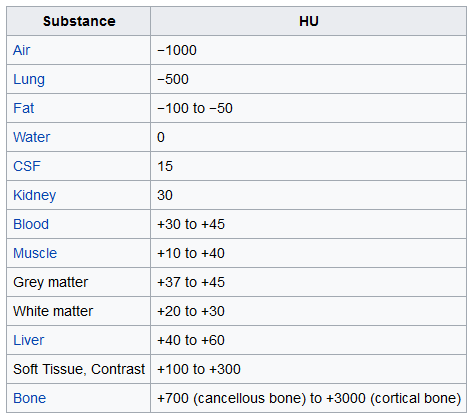

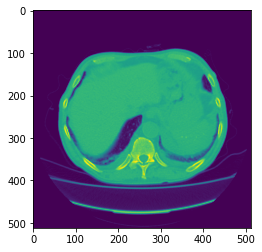

In [249]:
# Set outside-of-scan pixels to 0
# The intercept is usually -1024, so air is approximately 0
test_image = images[11]
dcm = slices[11]
plt.imshow(test_image)

#### 3. Resampling to isotropic resolution

Различные кадры могут быть с разным расстоянием между кадрами SliceThikness и разным расстоянием между пикселями PixelSpacing
Прежде чем тренировать сетку нужно привести все изображения к одному размеру.

In [289]:
from scipy import ndimage
def resample(images, spacing, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    resize_factor = spacing / new_spacing
    new_real_shape = images.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / images.shape
    new_spacing = spacing / real_resize_factor
    
    images = ndimage.interpolation.zoom(images, real_resize_factor, mode='nearest')
    
    return images, new_spacing

In [356]:
400/0.782

511.5089514066496

In [295]:
spacing = np.array([slices[0].SliceThickness] + list(slices[0].PixelSpacing), dtype=np.float32)
images_resampled, new_spacing = resample(images, spacing)

In [296]:
images_resampled.shape

(300, 400, 400)

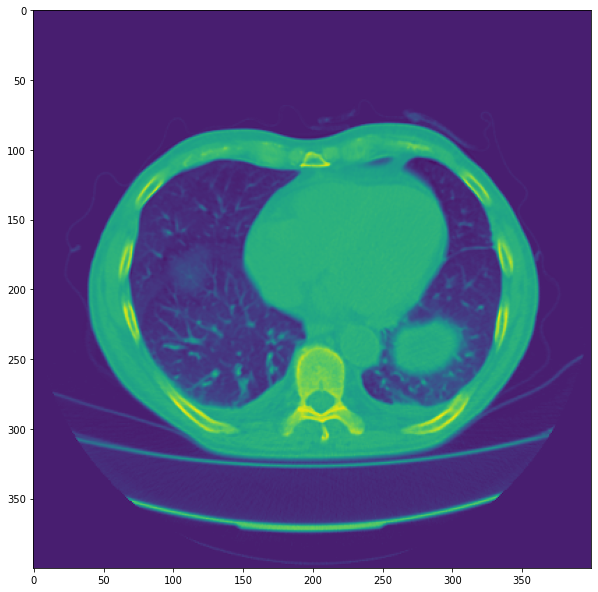

In [355]:
fig = plt.figure(figsize = (10, 12))
plt.imshow(images_resampled[100])

In [310]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, normals, values= measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    


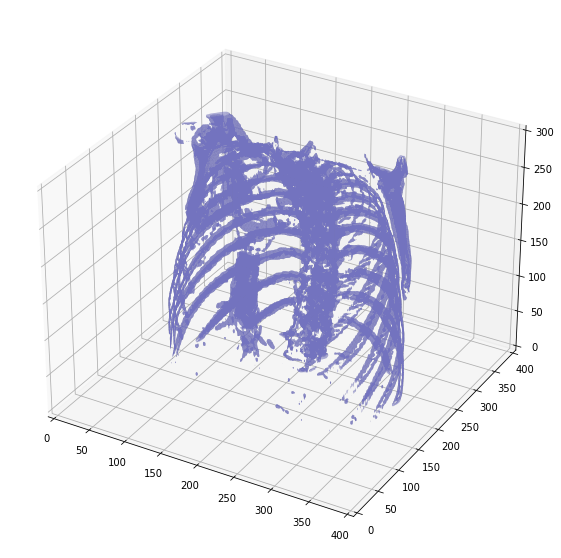

In [316]:
plot_3d(images_resampled, 400)

## Lung Segmentation

In [322]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [319]:
segmented_lungs = segment_lung_mask(images_resampled, False)
segmented_lungs_fill = segment_lung_mask(images_resampled, True)

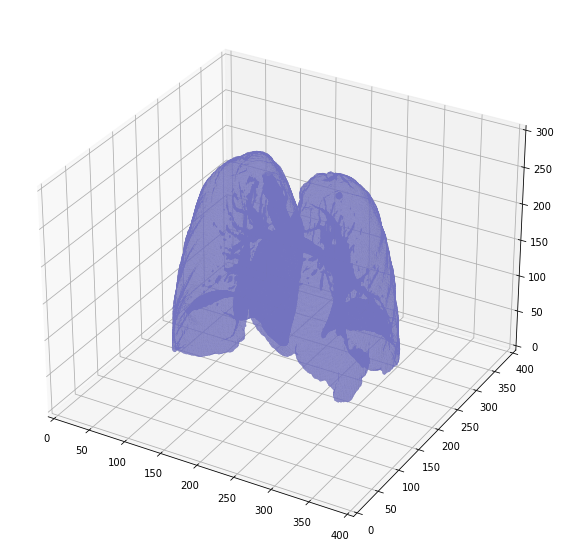

In [321]:
plot_3d(segmented_lungs, 0)

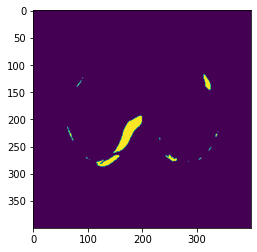

In [370]:
test_image = segmented_lungs[50]
plt.imshow(test_image)

In [368]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

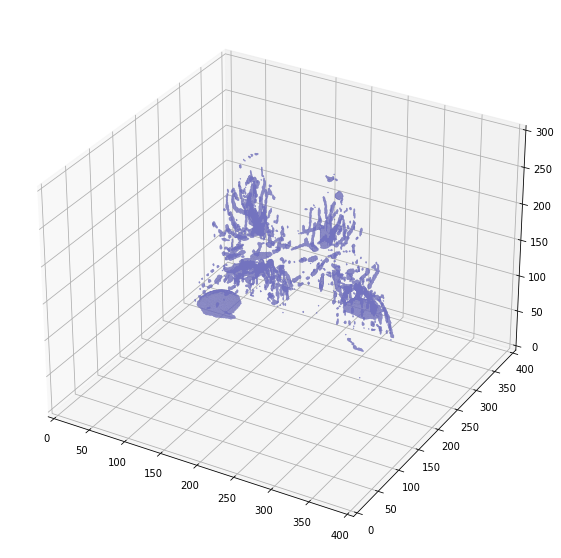

In [323]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

### Преобразуем из HU в 256 gray

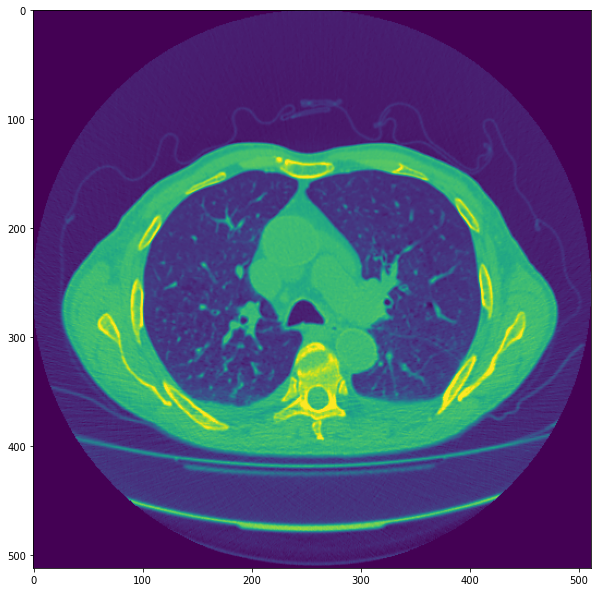

In [82]:
img_256 = ((img_clipped + 1200)/1800 * 255).astype(int)
fig = plt.figure(figsize = (10, 12))
plt.imshow(img_256)

### Убираем мелкие детали с изображения

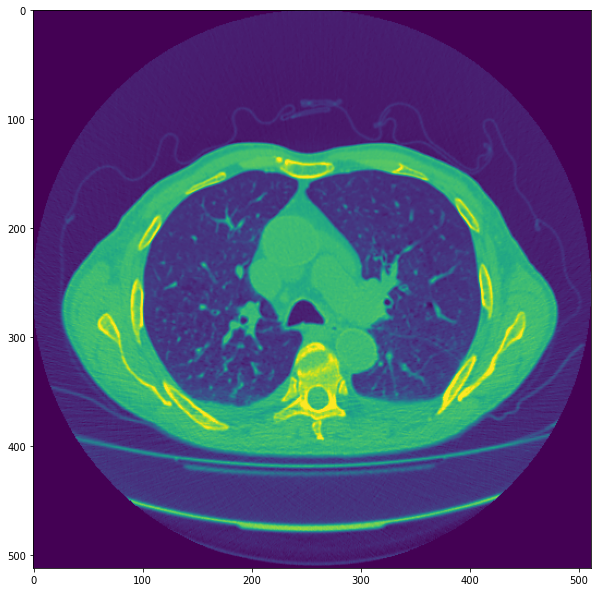

In [91]:
imgx=img_256.astype(np.uint8)
#find all your connected components (white blobs in your image)
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(imgx, connectivity=8)
#connectedComponentswithStats yields every seperated component with information on each of them, such as size
#the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
sizes = stats[1:, -1]; nb_components = nb_components - 1

min_size = 1

#your answer image
img2 = np.zeros((output.shape))
#for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img2[output == i + 1] = 255
        
fig = plt.figure(figsize = (10, 12))
plt.imshow(imgx)

In [97]:
## Test detecting small elements

In [99]:
img_path = data_path + '/Small_elements.png'

In [100]:
img_path

'/home/samsmu/Data/Lung/CT/Small_elements.png'

In [110]:
src = cv.imread(cv.samples.findFile(img_path))
src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
src_gray = cv.blur(src_gray, (3,3))

threshold =255

In [111]:
# Detect edges using Canny
canny_output = cv.Canny(src_gray, threshold, threshold * 2)
# Find contours
contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

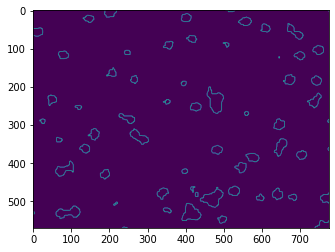

In [113]:
plt.imshow(canny_output)

In [115]:
# Draw contours
import random as rng
drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
for i in range(len(contours)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv.drawContours(drawing, contours, i, color, 2, cv.LINE_8, hierarchy, 0)


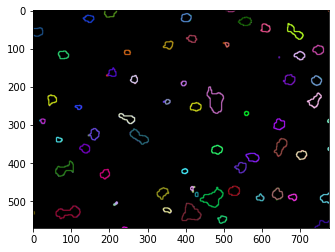

In [118]:
plt.imshow(drawing)

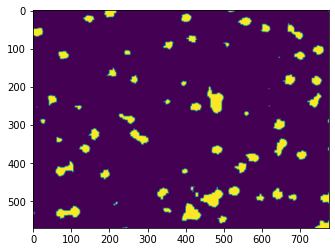

In [104]:
plt.imshow(src_gray)